<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import itertools
random.seed(10)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# DATA PROCESSING

In [3]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'
test_dir = '/content/drive/My Drive/Colab Notebooks/charts/Test'

In [4]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
nb_test_samples = 140
epochs = 100
batch_size = 16

In [5]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [ ]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
#import cv2
#import numpy as np
#from PIL import Image
#def myFunc(image):
 #   image = np.array(image)
  #  hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
   # hsv_image = hsv_image.astype('float32')
    #hsv_image = hsv_image / 255.0
    #return Image.fromarray(hsv_image)

In [6]:
# Inspired by random crop functionality from https://jkjung-avt.github.io/keras-image-cropping/
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        #noise_factor = 0.1
        noise = np.random.normal(0.0, scale=sigma, size=batch_x.shape)
        #noise = np.random.normal(0, 0.1, batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [105]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9) #Range starts from 0.6 as I do not expect very dark chart image inputs
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical')

#Test generator has the same dataset as the validation generator but with shuffling turned off to facilitate confusion matrix plotting
test_generator = test_datagen.flow_from_directory(
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size,
	class_mode='categorical',
	shuffle=False
)

#Adding noise
train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

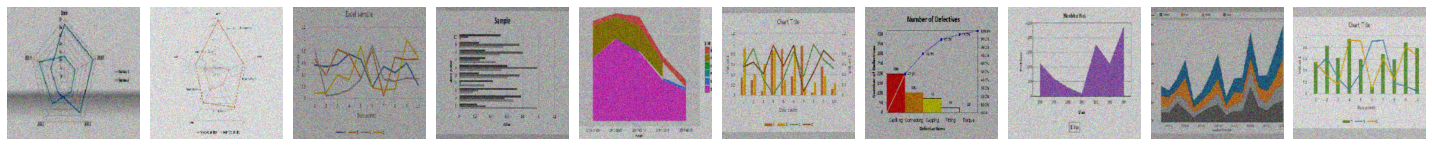

In [10]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

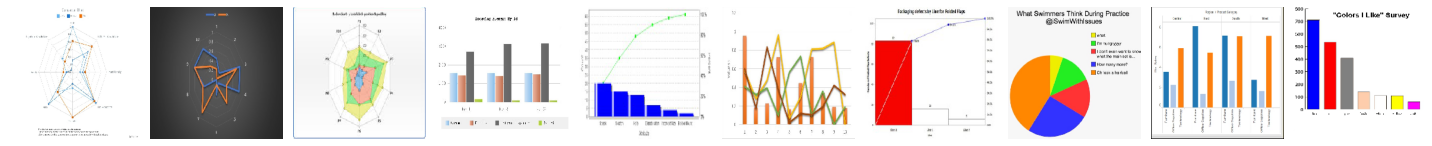

In [11]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

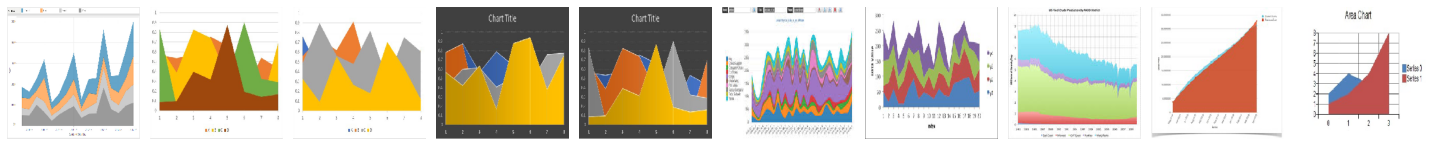

In [12]:
sample_test_images, _ = next(test_generator)
plotImages(sample_test_images[:10])

#BASELINE CNN MODEL

In [38]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


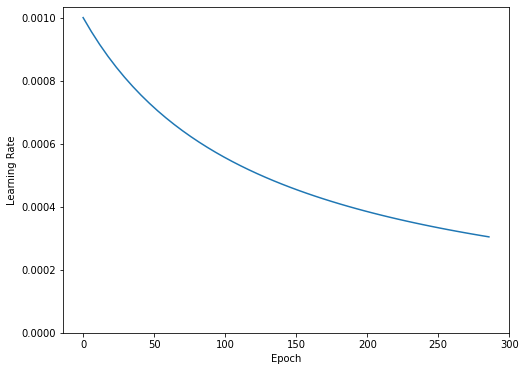

In [39]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [40]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)            

In [41]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=300, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/300
35/35 [==============================] - 17s 496ms/step - loss: 2.2739 - accuracy: 0.2339 - val_loss: 1.8911 - val_accuracy: 0.2422
Epoch 2/300
35/35 [==============================] - 17s 477ms/step - loss: 1.6496 - accuracy: 0.3393 - val_loss: 1.6894 - val_accuracy: 0.3984
Epoch 3/300
35/35 [==============================] - 17s 481ms/step - loss: 1.5963 - accuracy: 0.3554 - val_loss: 1.6275 - val_accuracy: 0.4453
Epoch 4/300
35/35 [==============================] - 17s 483ms/step - loss: 1.4612 - accuracy: 0.4214 - val_loss: 1.6091 - val_accuracy: 0.4062
Epoch 5/300
35/35 [==============================] - 17s 474ms/step - loss: 1.1971 - accuracy: 0.5196 - val_loss: 1.7451 - val_accuracy: 0.5078
Epoch 6/300
35/35 [==============================] - 17s 473ms/step - loss: 1.0568 - accuracy: 0.5946 - val_loss: 1.7656 - val_accuracy: 0.4297
Epoch 7/300
35/35 [==============================] - 17s 483ms/step - loss: 0.9632 - accuracy: 0.6018 - val_loss: 1.5856 - val_accuracy:

In [43]:
model.save('/content/drive/My Drive/Colab Notebooks/cnn baseline model', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/cnn baseline model/assets


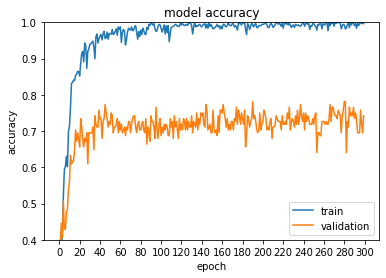

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,320, 20))
plt.ylim(0.4,1.0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

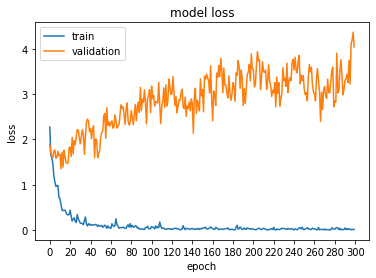

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,320, 20))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
load = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/cnn baseline model')

In [68]:
y_pred = load.predict(test_generator)
y_prediction = np.argmax(y_pred , axis=1)
conf_matrix=confusion_matrix(test_generator.classes, y_prediction)

In [69]:
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']

In [70]:
#Confusion matrix plotting function taken from https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.6  0.05 0.3  0.   0.   0.  ]
 [0.   0.05 0.6  0.05 0.05 0.   0.25]
 [0.   0.2  0.05 0.7  0.05 0.   0.  ]
 [0.05 0.   0.   0.   0.95 0.   0.  ]
 [0.   0.   0.2  0.   0.05 0.7  0.05]
 [0.   0.   0.25 0.   0.   0.05 0.7 ]]


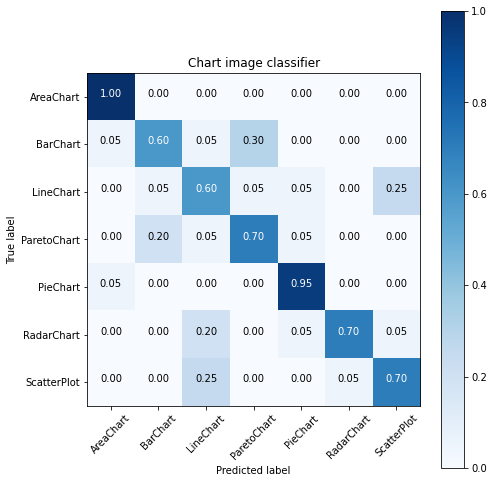

In [71]:
final_confusion_matrix = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=True, title='Chart image classifier')

In [72]:
print(classification_report(test_generator.classes, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

   AreaChart       0.91      1.00      0.95        20
    BarChart       0.71      0.60      0.65        20
   LineChart       0.52      0.60      0.56        20
 ParetoChart       0.67      0.70      0.68        20
    PieChart       0.86      0.95      0.90        20
  RadarChart       0.93      0.70      0.80        20
 ScatterPlot       0.70      0.70      0.70        20

    accuracy                           0.75       140
   macro avg       0.76      0.75      0.75       140
weighted avg       0.76      0.75      0.75       140



[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.466599
[t-SNE] KL divergence after 1000 iterations: 0.634947


Text(0.5, 1.0, 't-SNE Visualisation')

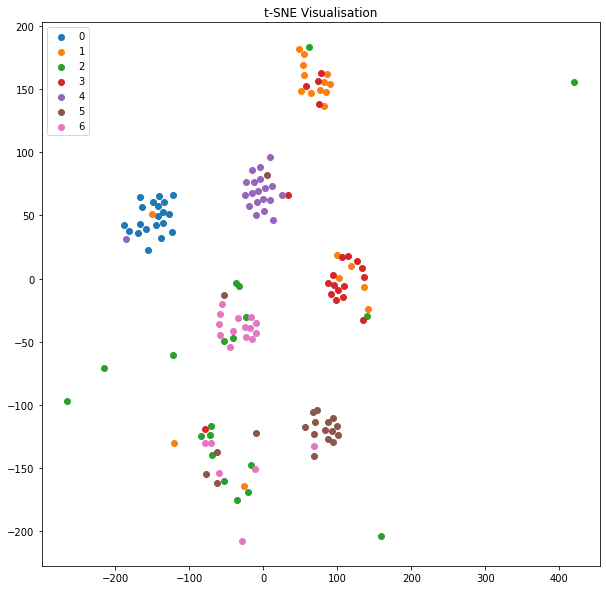

In [81]:
# Reduce to 7 dimensions with PCA
pca = PCA(n_components=7)
pca_results = pca.fit_transform(y_pred)
#print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Apply t-SNE on the PCA results to reduce to 2D
tsne = TSNE(n_components=2, perplexity=7, learning_rate=300, verbose = 1)
tsne_results = tsne.fit_transform(pca_results[:140])

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(test_generator.classes[:140], num_classes = 7)

#Plot the points in 2D
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(0,7):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=colour)
plt.legend()
plt.title('t-SNE Visualisation')

#ABLATION STUDY

# <H4>Remove data augementation and gaussian noise - keep learning rate scheduling, keep all classes

In [82]:
train_datagen_2 = ImageDataGenerator(rescale=1. /255)

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

Found 560 images belonging to 7 classes.


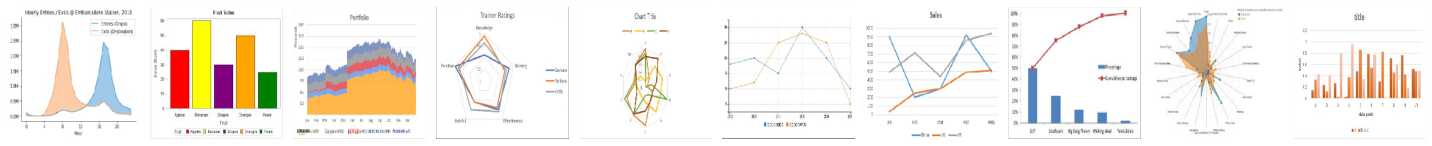

In [83]:
sample_training_images, _ = next(train_generator_2)
plotImages(sample_training_images[:10])

In [84]:
model_repeat = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [85]:
model_repeat.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [86]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model_repeat.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator , 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 6s 176ms/step - loss: 2.8237 - accuracy: 0.2625 - val_loss: 1.6978 - val_accuracy: 0.4219
Epoch 2/100
35/35 [==============================] - 6s 169ms/step - loss: 1.1429 - accuracy: 0.5643 - val_loss: 1.2983 - val_accuracy: 0.5625
Epoch 3/100
35/35 [==============================] - 6s 167ms/step - loss: 0.6823 - accuracy: 0.7375 - val_loss: 1.1872 - val_accuracy: 0.6172
Epoch 4/100
35/35 [==============================] - 6s 169ms/step - loss: 0.3725 - accuracy: 0.8696 - val_loss: 1.3554 - val_accuracy: 0.6641
Epoch 5/100
35/35 [==============================] - 6s 169ms/step - loss: 0.2221 - accuracy: 0.9304 - val_loss: 1.4304 - val_accuracy: 0.6875
Epoch 6/100
35/35 [==============================] - 6s 168ms/step - loss: 0.1050 - accuracy: 0.9714 - val_loss: 1.3765 - val_accuracy: 0.7266
Epoch 7/100
35/35 [==============================] - 6s 170ms/step - loss: 0.0962 - accuracy: 0.9768 - val_loss: 1.8802 - val_accuracy: 0.6484

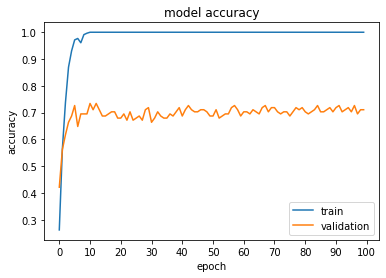

In [87]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

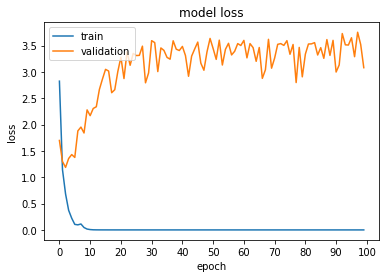

In [88]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.2  0.55 0.05 0.1  0.05 0.   0.05]
 [0.1  0.05 0.5  0.05 0.05 0.   0.25]
 [0.   0.35 0.   0.55 0.   0.05 0.05]
 [0.   0.   0.   0.   0.95 0.05 0.  ]
 [0.   0.   0.05 0.   0.05 0.9  0.  ]
 [0.   0.   0.35 0.   0.   0.1  0.55]]


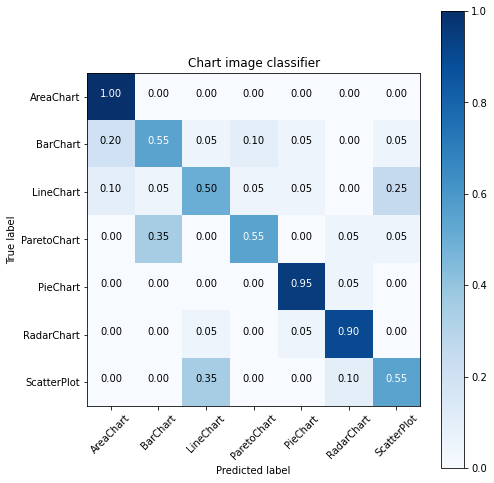

In [89]:
y_pred_1 = model_repeat.predict(test_generator)
y_prediction_1 = np.argmax(y_pred_1 , axis=1)
conf_matrix_1=confusion_matrix(test_generator.classes, y_prediction_1)
final_confusion_matrix_1 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_1, classes=target_names, normalize=True, title='Chart image classifier')

#<H4>Remove gaussian noise - keep learning rate scheduling, data augmentation and all classes

In [90]:
model_repeat_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [91]:
model_repeat_4.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)            

In [92]:
history4 = model_repeat_4.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 13s 369ms/step - loss: 2.2590 - accuracy: 0.2661 - val_loss: 1.6679 - val_accuracy: 0.5156
Epoch 2/100
35/35 [==============================] - 13s 361ms/step - loss: 1.2668 - accuracy: 0.4946 - val_loss: 1.3996 - val_accuracy: 0.5078
Epoch 3/100
35/35 [==============================] - 13s 363ms/step - loss: 1.0105 - accuracy: 0.6089 - val_loss: 1.1679 - val_accuracy: 0.6250
Epoch 4/100
35/35 [==============================] - 13s 367ms/step - loss: 0.7825 - accuracy: 0.7036 - val_loss: 1.4153 - val_accuracy: 0.5703
Epoch 5/100
35/35 [==============================] - 13s 362ms/step - loss: 0.5789 - accuracy: 0.7964 - val_loss: 1.4160 - val_accuracy: 0.6484
Epoch 6/100
35/35 [==============================] - 13s 365ms/step - loss: 0.5270 - accuracy: 0.8089 - val_loss: 1.4421 - val_accuracy: 0.6250
Epoch 7/100
35/35 [==============================] - 13s 370ms/step - loss: 0.4682 - accuracy: 0.8304 - val_loss: 1.4512 - val_accuracy:

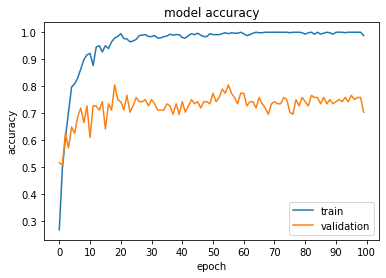

In [93]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

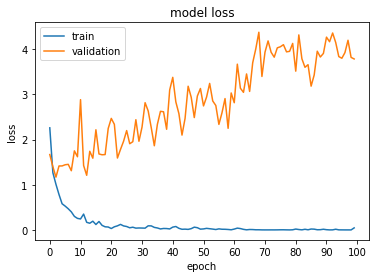

In [94]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [98]:
y_pred_4 = model_repeat_4.predict(test_generator)
y_prediction_4 = np.argmax(y_pred_4 , axis=1)
conf_matrix_4=confusion_matrix(test_generator.classes, y_prediction_4)

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.3  0.6  0.   0.05 0.05 0.   0.  ]
 [0.1  0.1  0.6  0.05 0.   0.   0.15]
 [0.05 0.35 0.05 0.4  0.1  0.05 0.  ]
 [0.05 0.   0.   0.   0.95 0.   0.  ]
 [0.   0.   0.05 0.   0.1  0.8  0.05]
 [0.   0.05 0.4  0.   0.   0.   0.55]]


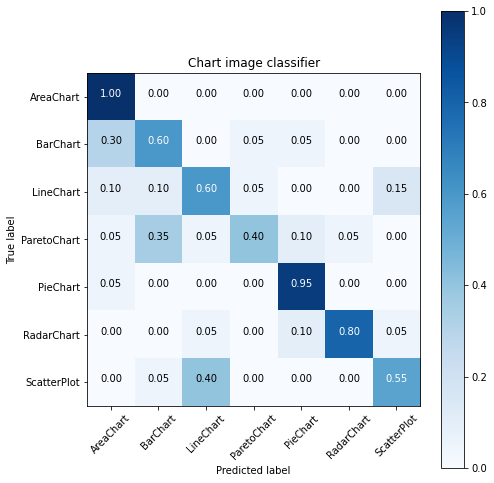

In [99]:
final_confusion_matrix_4 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_4, classes=target_names, normalize=True, title='Chart image classifier')

#<H4>Keep gaussian noise, learning rate scheduling & data aug - remove bar chart and line chart classes (only 5 charts)

In [131]:
train_generator_5 = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical',
  classes=["AreaChart", "ParetoChart", "PieChart", "RadarChart", "ScatterPlot"]) 

validation_generator_5 = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  classes=["AreaChart", "ParetoChart", "PieChart", "RadarChart", "ScatterPlot"])

test_generator_5 = test_datagen.flow_from_directory(
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
	shuffle = False,
  classes=["AreaChart", "ParetoChart", "PieChart", "RadarChart", "ScatterPlot"]
)

#Adding noise
train_noisy_5 = noisy_generator(train_generator_5)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


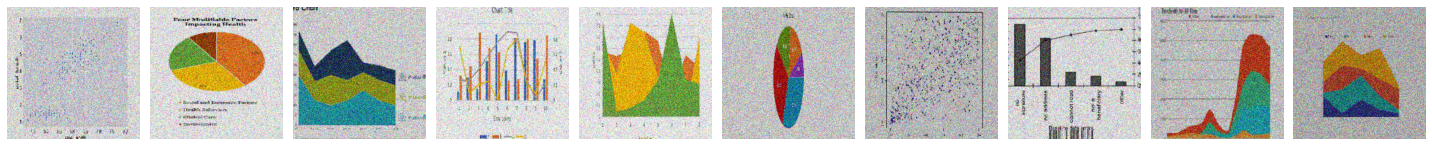

In [132]:
sample_training_images_5, _ = next(train_noisy_5)
plotImages(sample_training_images_5[:10])

In [133]:
model_repeat_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [134]:
model_repeat_5.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 50176)           

In [135]:
train_samples = 400
val_samples = 100
test_samples = 100

In [127]:
history5 = model_repeat_5.fit( 
	train_noisy_5, 
	steps_per_epoch=train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_5, 
	validation_steps= val_samples // batch_size)

Epoch 1/100
25/25 [==============================] - 12s 476ms/step - loss: 3.0004 - accuracy: 0.2775 - val_loss: 1.4637 - val_accuracy: 0.4583
Epoch 2/100
25/25 [==============================] - 12s 467ms/step - loss: 1.3724 - accuracy: 0.4900 - val_loss: 1.1856 - val_accuracy: 0.5417
Epoch 3/100
25/25 [==============================] - 12s 474ms/step - loss: 1.1561 - accuracy: 0.5700 - val_loss: 0.9763 - val_accuracy: 0.7292
Epoch 4/100
25/25 [==============================] - 12s 490ms/step - loss: 0.8232 - accuracy: 0.6575 - val_loss: 0.9095 - val_accuracy: 0.7188
Epoch 5/100
25/25 [==============================] - 12s 478ms/step - loss: 0.7723 - accuracy: 0.7050 - val_loss: 0.8444 - val_accuracy: 0.7188
Epoch 6/100
25/25 [==============================] - 12s 485ms/step - loss: 0.7011 - accuracy: 0.7250 - val_loss: 0.8035 - val_accuracy: 0.7188
Epoch 7/100
25/25 [==============================] - 12s 474ms/step - loss: 0.6062 - accuracy: 0.7725 - val_loss: 0.8280 - val_accuracy:

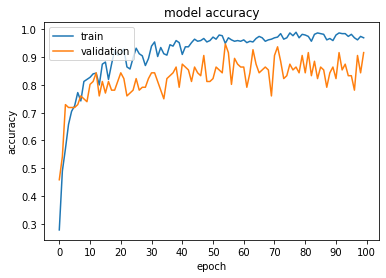

In [128]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [129]:
y_pred_5 = model_repeat_5.predict(test_generator_5)
y_prediction_5 = np.argmax(y_pred_5 , axis=1)
conf_matrix_5=confusion_matrix(test_generator_5.classes, y_prediction_5)
target_names_5 = ["AreaChart", "ParetoChart", "PieChart", "RadarChart", "ScatterPlot"]

Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.15 0.7  0.05 0.1  0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.05 0.95 0.  ]
 [0.   0.05 0.   0.05 0.9 ]]


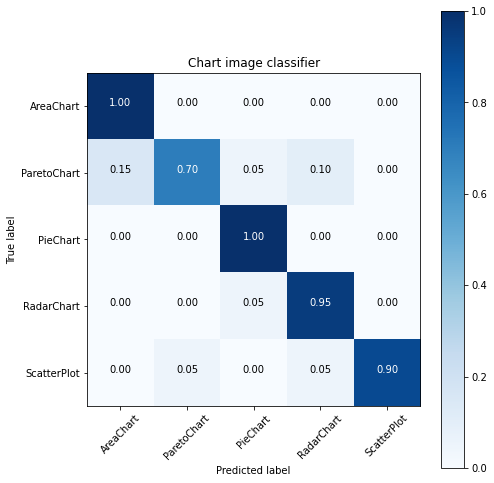

In [130]:
final_confusion_matrix_5 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_5, classes=target_names_5, normalize=True, title='Chart image classifier')